In [8]:
#Biblio
import numpy as np
from skimage.io import imread
import time
import platform
import tempfile
import os
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import skimage
from skimage import io as skio
import IPython
from skimage.transform import rescale
from skimage.io import imread
import sys
from skimage import metrics, restoration


In [9]:

def noisegauss(im,br):
    """ Cette fonction ajoute un bruit blanc gaussier d'ecart type br
       a l'image im et renvoie le resultat"""
    imt=np.float32(im.copy())
    sh=imt.shape
    bruit=br*np.random.randn(*sh)
    imt=imt+bruit
    return imt

def viewimage(im, normalize=True,z=1,order=0,titre='',displayfilename=False):
    imin=im.copy().astype(np.float32)
    imin = rescale(imin, z, order=order)
    if normalize:
        imin-=imin.min()
        if imin.max()>0:
            imin/=imin.max()
    else:
        imin=imin.clip(0,255)/255 
    imin=(imin*255).astype(np.uint8)
    filename=tempfile.mktemp(titre+'.png')
    if displayfilename:
        print (filename)
    plt.imsave(filename, imin, cmap='gray')
    IPython.display.display(IPython.display.Image(filename))

def distpatch(patch1, patch2, khard=8):
    """
    Calcul distance entre deux patchs (sans seuillage).

    patch1, patch2: 1D arrays (flatten)
    """
    if patch1.size != patch2.size:
        print('Error: two patches should be in same size in function distpatch().\n')
        sys.exit()

    p1 = patch1.astype(np.float32)
    p2 = patch2.astype(np.float32)

    diff = p1 - p2
    dist = np.sqrt(np.sum(diff * diff)) / (khard ** 2)  # Normalization
    return dist


In [10]:
def nlm_patchwise(img, patch_size=3, search_window=21, h=0.4*15, sigma=15):
    """
    Implémentation patchwise du Non-Local Means.

    Args:
        img: Image en niveaux de gris (numpy array).
        patch_size: Taille des patches (doit être impair).
        search_window: Taille de la fenêtre de recherche (doit être impair).
        h: Paramètre de filtrage (ex: h = 0.4 * sigma).
        sigma: Écart-type du bruit.

    Returns:
        Image débruitée (numpy array).
    """
    # Initialisation
    half_patch = patch_size // 2
    half_search = search_window // 2
    accumulated_weights = np.zeros_like(img, dtype=np.float32)
    accumulated_values = np.zeros_like(img, dtype=np.float32)

    # Parcourir chaque pixel central d'un patch
    for i in range(half_patch, img.shape[0] - half_patch):
        for j in range(half_patch, img.shape[1] - half_patch):
            # Extraire le patch de référence
            patch = img[i-half_patch:i+half_patch+1, j-half_patch:j+half_patch+1]

            # Fenêtre de recherche
            i_start = max(i - half_search, half_patch)
            i_end = min(i + half_search, img.shape[0] - half_patch)
            j_start = max(j - half_search, half_patch)
            j_end = min(j + half_search, img.shape[1] - half_patch)

            # Initialisation pour le patch débruité
            weighted_patch_sum = np.zeros_like(patch, dtype=np.float32)
            weights_sum_patch = 0.0

            # Parcourir les patches voisins
            for k in range(i_start, i_end + 1):
                for l in range(j_start, j_end + 1):
                    k1, l1 = k - half_patch, l - half_patch
                    k2, l2 = k + half_patch, l + half_patch
                    neighbor_patch = img[k1:k2+1, l1:l2+1]

                    # Taille minimale pour normaliser la distance
                    h1, w1 = patch.shape
                    h2, w2 = neighbor_patch.shape
                    min_h, min_w = min(h1, h2), min(w1, w2)
                    min_size = min_h * min_w

                    # Calcul de la distance normalisée
                    diff = patch[:min_h, :min_w] - neighbor_patch[:min_h, :min_w]
                    dist = np.sum(diff**2) / min_size
                    weight = np.exp(-max(dist - 2*(sigma**2), 0) / (h**2))

                    weighted_patch_sum[:min_h, :min_w] += weight * neighbor_patch[:min_h, :min_w]
                    weights_sum_patch += weight
            # Estimation du patch débruité
            if weights_sum_patch > 0:
                denoised_patch = weighted_patch_sum / weights_sum_patch
            else:
                denoised_patch = patch  # Garde le patch original si aucun poids valide

            # Agrégation des estimations pour chaque pixel du patch
            for di in range(patch_size):
                for dj in range(patch_size):
                    pixel_i = i - half_patch + di
                    pixel_j = j - half_patch + dj
                    accumulated_weights[pixel_i, pixel_j] += 1.0
                    accumulated_values[pixel_i, pixel_j] += denoised_patch[di, dj]

    # Normalisation finale
    denoised_img = np.divide(
        accumulated_values,
        accumulated_weights,
        out=np.zeros_like(accumulated_values),
        where=accumulated_weights != 0
    )

    return np.clip(denoised_img, 0, 255).astype(np.uint8)



In [16]:
def nlm_patchwise_optimized(img, patch_size=3, search_window=21, h=0.4*15, sigma=15):
    """
    Implémentation patchwise du Non-Local Means optimisée.
    
    Optimisations :
    - Padding reflect pour éviter les branches compliquées aux bords
    - Vectorisation partielle (distance sur tous les patches en une opération)
    - Réduction des boucles imbriquées
    """
    img = img.astype(np.float32)
    half_patch = patch_size // 2
    half_search = search_window // 2
    
    # Padding de l'image avec mode reflect
    padded = np.pad(img, half_patch, mode='reflect')
    H, W = img.shape
    
    accumulated_weights = np.zeros((H, W), dtype=np.float32)
    accumulated_values = np.zeros((H, W), dtype=np.float32)
    
    eps = 1e-12
    
    # Parcourir chaque pixel (sur image originale, indices décalés sur image paddée)
    for i in range(H):
        for j in range(W):
            # Position dans image paddée
            pi = i + half_patch
            pj = j + half_patch
            
            # Extraire patch de référence (toujours carré et complet avec padding)
            ref_patch = padded[pi - half_patch : pi + half_patch + 1,
                               pj - half_patch : pj + half_patch + 1]
            ref_flat = ref_patch.ravel()
            
            # Fenêtre de recherche (en coordonnées image originale)
            i_start = max(i - half_search, 0)
            i_end = min(i + half_search + 1, H)
            j_start = max(j - half_search, 0)
            j_end = min(j + half_search + 1, W)
            
            weighted_patch_sum = np.zeros_like(ref_patch, dtype=np.float32)
            weights_sum_patch = 0.0
            
            # Parcourir les positions de recherche
            for k in range(i_start, i_end):
                for l in range(j_start, j_end):
                    pk = k + half_patch
                    pl = l + half_patch
                    
                    # Extraire patch voisin (toujours complet avec padding)
                    neigh_patch = padded[pk - half_patch : pk + half_patch + 1,
                                        pl - half_patch : pl + half_patch + 1]
                    neigh_flat = neigh_patch.ravel()
                    
                    # Distance L2 vectorisée
                    diff = ref_flat - neigh_flat
                    dist = np.sum(diff * diff) / (patch_size * patch_size)
                    
                    # Poids avec correction de bruit
                    corrected_dist = max(dist - 2.0 * (sigma ** 2), 0.0)
                    weight = np.exp(-corrected_dist / (h * h + eps))
                    
                    weighted_patch_sum += weight * neigh_patch
                    weights_sum_patch += weight
            
            # Normalisation du patch
            if weights_sum_patch > eps:
                denoised_patch = weighted_patch_sum / weights_sum_patch
            else:
                denoised_patch = ref_patch
            
            # Agrégation (vectorisée)
            accumulated_weights[i : i + 1, j : j + 1] += 1.0
            accumulated_values[i : i + 1, j : j + 1] += denoised_patch[half_patch, half_patch]
    
    # Normalisation finale
    denoised_img = np.divide(
        accumulated_values,
        accumulated_weights,
        out=np.zeros_like(accumulated_values),
        where=accumulated_weights > eps
    )
    
    return np.clip(denoised_img, 0, 255).astype(np.uint8)

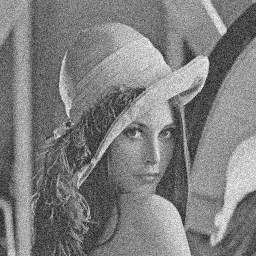

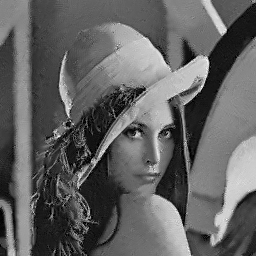

In [ ]:
im=imread('img/AnyConv.com___Fish_data_raw_11_HV140_P100510027.tif')
img=noisegauss(im,20)
viewimage(img,titre='Noisy Image',normalize=True) 
denoised_img = nlm_patchwise_optimized(img, patch_size=5, search_window=21, h=0.4*15, sigma=20)
viewimage(denoised_img, titre='Denoised Image with Patchwise NLM', normalize=True)

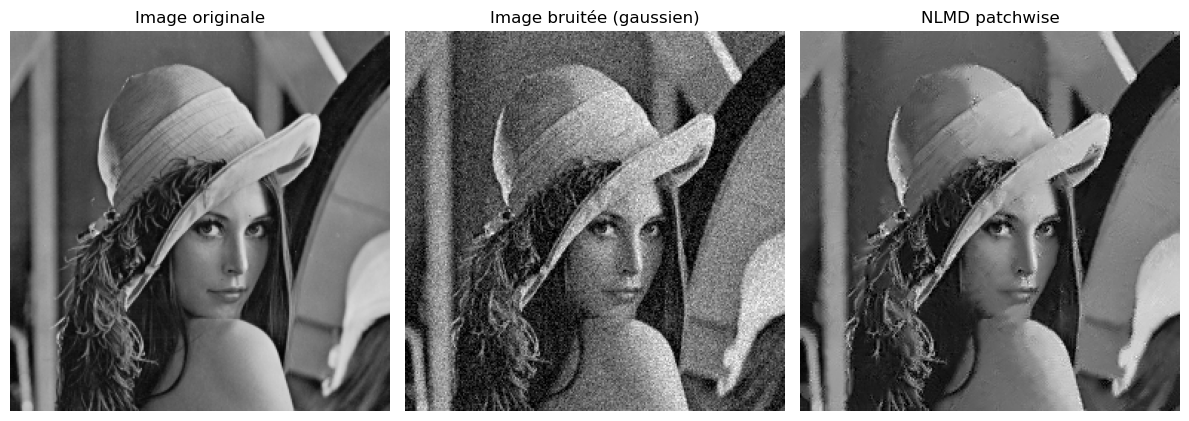

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(12, 10))
ax = axes.ravel()
ax[0].imshow(im, cmap='gray', vmin=0, vmax=255)
ax[0].set_title('Image originale')
ax[1].imshow(img, cmap='gray', vmin=0, vmax=255)
ax[1].set_title('Image bruitée (gaussien)')
ax[2].imshow(denoised_img, cmap='gray', vmin=0, vmax=255)
ax[2].set_title('NLMD patchwise')


for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

In [19]:
psnr_nlm = metrics.peak_signal_noise_ratio(im, denoised_img)
print(f"PSNR NLM patchwise: {psnr_nlm:.2f} dB")

PSNR NLM patchwise: 28.46 dB


In [ ]:
#Testing sur vrai image
im=imread('img/AnyConv.com___Fish_data_raw_11_HV140_P100510027.tif')
denoised_img = []
psnr_nlm = []
t=[10,20,30]
for i in range(len(t)):
    denoised_img.append(nlm_patchwise_optimized(im, patch_size=5, search_window=21, h=0.4*t[i], sigma=t[i]))
    psnr_nlm.append(metrics.peak_signal_noise_ratio(im, denoised_img[i]))
    print(f"Sigma: {t[i]} - PSNR NLM patchwise: {psnr_nlm[i]:.2f} dB")

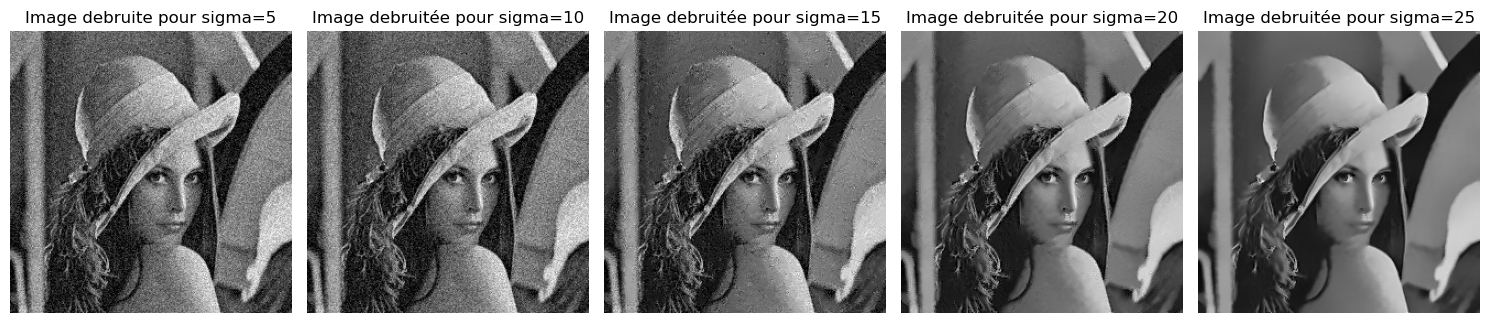

In [27]:
fig, axes = plt.subplots(1, 5, figsize=(15, 10))
ax = axes.ravel()
ax[0].imshow(denoised_img[0], cmap='gray', vmin=0, vmax=255)
ax[0].set_title('Image debruite pour sigma=5')
ax[1].imshow(denoised_img[1], cmap='gray', vmin=0, vmax=255)
ax[1].set_title('Image debruitée pour sigma=10')
ax[2].imshow(denoised_img[2], cmap='gray', vmin=0, vmax=255)
ax[2].set_title('Image debruitée pour sigma=15')
ax[3].imshow(denoised_img[3], cmap='gray', vmin=0, vmax=255)
ax[3].set_title('Image debruitée pour sigma=20')
ax[4].imshow(denoised_img[4], cmap='gray', vmin=0, vmax=255)
ax[4].set_title('Image debruitée pour sigma=25')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()